# Manual Feature Engineering

Feature engineering is the process of creating new features (also called explantory or predictor variables) out of an existing dataset in order to help a machine learning model learn a prediction problem. In many cases, the dataset is spread across many relational tables linked by keys. Because a machine learning model can only use a single table when training, feature engineering requires creating all of the features in one table with the objective of capturing as many useful relationships in the data as possible. Once all of the data has been gathered into a single table, the model is trained on the training data and then assessed by making predictions on the hold-out testing data. 

Traditionally, the task of feature engineering is carried out by hand, often involving domain expertise and many individual steps. While feature engineering is crucial to the success of a machine learning project, it can also be extremely tedious and time-consuming. The ultimate dream technique in machine learning would be a method that can automatically extract useful features from a set of related data tables that could serve as an aid to the data scientist. Humans are limited both by time constraints and by creativity when it comes to designing new features, and as a result, it is impossible to know when all the options have been exhuasted and if the resulting set of features is as good as it could be. 

In this notebook, we will walk through the steps of manual feature engineering for a machine learning task: predicting whether or not an applicant will default on a loan. This is a supervised classification task: given historical socioeconomic and loan data of applicants, train a machine learning model to predict whether a new applicant will default on a loan.

## Dataset

The Home Credit Default Risk dataset consists of seven tables of data:

* application_train/application_test: the main training/testing data for each loan application at Home Credit. The information includes both socioeconomic indicators for the client and loan-specific characteristics. Each loan has its own row and is uniquely identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions (not Home Credit). Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits. The previous credits are uniquely identified by the feature `SK_ID_BUREAU`.
* bureau_balance: monthly balance data about the credits in bureau. Each row has information for one month about a previous credit and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is uniquely identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

The image below shows the seven tables and the keys linking them:

![](../../images/kaggle_home_credit/home_credit_data.png)


Manual feature engineering will require extracting all of the data into a single table. New features can be made by manipulating columns from the original `application` data (such as dividing or subtracting two columns) or by using the children data tables. The children data tables must be grouped by a parent variable (such as `SK_ID_CURR`) and then aggregated for the parent. 

First, we will concentrate on the main dataframe, `application`. 

In [1]:
import pandas as pd
import numpy as np

RSEED = 50

In [2]:
app_train = pd.read_csv('../../data/kaggle_home_credit/application_train.csv')
app_test = pd.read_csv('../../data/kaggle_home_credit/application_test.csv')
app_test['TARGET'] = np.nan

# Combine train/test into one dataset
app = app_train.append(app_test, sort=False)

print('There are originally {} features.'.format(app.shape[1] - 2))

There are originally 120 features.


(One of the columns is the key, `SK_ID_CURR`, and one of the columns is the label, `TARGET`.)

### Baseline Model 

Before doing any feature engineering, it's important to establish a baseline performance measure. This will let us get a sense if the actions we take are useful and improve the model. For a baseline model, we will use the default hyperparameters values of the Gradient Boosting Machine in the LightGBM library. The number of estimators will be selected using 5-fold cross validation with early stopping if scores on the validation set have not improved in 100 iterations.

First the categorical features will be one-hot encoded. 

In [3]:
import lightgbm as lgb


train_labels = np.array(app_train['TARGET'].astype(np.int32)).reshape((-1, ))
train = pd.get_dummies(app_train.drop(columns = ['TARGET', 'SK_ID_CURR']))


# Create a training set
train_set = lgb.Dataset(train, label = train_labels)

# Find default hyperparameters
model = lgb.LGBMClassifier()
params = model.get_params()

# Number of estimators will be selected through early stopping
del params['n_estimators'] 

cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                    early_stopping_rounds = 100, seed = RSEED)

print('Baseline Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                           cv_results['auc-stdv'][-1]))
print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Baseline Cross Validation ROC AUC: 0.75565 with std: 0.00604.
Number of estimators trained: 141


## Domain Knowledge Features

A large part of manual feature engineering involves trying to use domain knowledge in order to build new features that are important for a particular problem. This may mean consulting experts, or it can be done in an experimental fashion, building features one at a time and testing them for usefulness. 

As an example, one potentially useful feature is the length of the loan. Although not given in the original data, this can be calculated by dividing the total loan amount by the total amount due each month. 

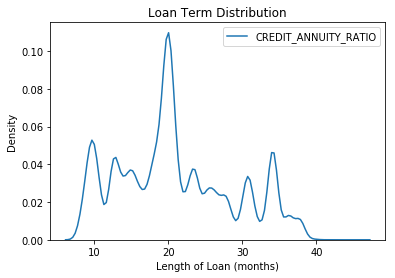

In [4]:
# Replace the anomalous values
app = app.replace({365243: np.nan})

app['CREDIT_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.kdeplot(app['CREDIT_ANNUITY_RATIO'].dropna());
plt.title('Loan Term Distribution'); plt.xlabel('Length of Loan (months)'); plt.ylabel('Density');

We can continue with this process, trying to create new features that we think are important based on the problem. For example, we can add features that compare the total credit amount `AMT_CREDIT` to the total income, `AMT_INCOME_TOTAL` or calculate the ratio of how long a client has been employed `DAYS_EMPLOYED` to their age `DAYS_BIRTH` (these values are recorded relative to the current application so are negative).

In [5]:
app['CREDIT_INCOME_RATIO'] = app['AMT_CREDIT'] / app['AMT_INCOME_TOTAL']
app['EMPLOYED_BIRTH_RATIO'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']

app['CREDIT_INCOME_RATIO'].describe()

count    356255.000000
mean          3.849476
std           2.635035
min           0.004808
25%           2.000000
50%           3.158857
75%           5.000000
max          84.736842
Name: CREDIT_INCOME_RATIO, dtype: float64

We can also use experimental results to construct new features. For example, when building a model using the Gradient Boosting Machine (as implemented in LightGBM), we can examine the feature importances from the model. This gives us an idea of what features are most important. Based on the feature importances of the model trained on the original dataset, we can try to make new features that capture useful information. 

In [6]:
model.n_estimators = len(cv_results)
model.fit(train, train_labels)

feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': model.feature_importances_})

feature_importances.sort_values('importance', ascending = False, inplace = True)
feature_importances.head()

,feature,importance
28,EXT_SOURCE_2,19
27,EXT_SOURCE_1,17
29,EXT_SOURCE_3,10
6,DAYS_BIRTH,5
106,CODE_GENDER_F,4


In [7]:
app['SOURCE_PRODUCT'] = app['EXT_SOURCE_1'] * app['EXT_SOURCE_2'] * app['EXT_SOURCE_3']
app['SOURCE_MEAN'] = app[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)

To try and get a sense if these features are important, we can use both quantitative measures - a Pearson correlation coefficient - and qualititative visualizations - a kernel density estimate plot colored by the value of whether the loan was repaid or not (this will only be for the training data where we have the label).

In [8]:
train_repaid = app[(app['TARGET'].notnull()) & (app['TARGET'] == 0)]
train_not_repaid = app[(app['TARGET'].notnull()) & (app['TARGET'] == 1)]

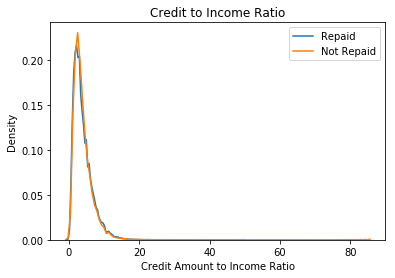

In [9]:
sns.kdeplot(train_repaid['CREDIT_INCOME_RATIO'], label = 'Repaid')
sns.kdeplot(train_not_repaid['CREDIT_INCOME_RATIO'], label = 'Not Repaid')

plt.legend(); plt.xlabel('Credit Amount to Income Ratio'); plt.ylabel('Density'); plt.title('Credit to Income Ratio');

/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


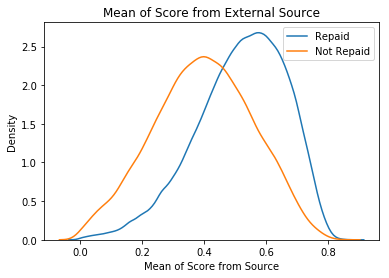

In [10]:
sns.kdeplot(train_repaid['SOURCE_MEAN'], label = 'Repaid')
sns.kdeplot(train_not_repaid['SOURCE_MEAN'], label = 'Not Repaid')

plt.legend(); plt.xlabel('Mean of Score from Source'); plt.ylabel('Density'); plt.title('Mean of Score from External Source');

Another method to find the value of new features is the correlation coefficient with the target. Although this only measures a linear relationship between two variables, it can be useful as a first approximation of whether or not a new feature will be relevant to the prediction task.

In [11]:
corrs = app.corr().sort_values('TARGET')

corrs['TARGET'].dropna().head()

SOURCE_MEAN      -0.222052
SOURCE_PRODUCT   -0.188552
EXT_SOURCE_3     -0.178919
EXT_SOURCE_2     -0.160472
EXT_SOURCE_1     -0.155317
Name: TARGET, dtype: float64

In [12]:
corrs['TARGET'].tail()

REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

In [13]:
app_train = app[app['TARGET'].notnull()].copy()
train = pd.get_dummies(app_train.drop(columns = ['TARGET', 'SK_ID_CURR']))


# Create a training set
train_set = lgb.Dataset(train, label = train_labels)

# Find default hyperparameters
model = lgb.LGBMClassifier()
params = model.get_params()

# Number of estimators will be selected through early stopping
del params['n_estimators'] 

cv_results = lgb.cv(params, train_set, num_boost_round = 10000, metrics = 'auc', 
                    early_stopping_rounds = 100, seed = RSEED)

print('Baseline Cross Validation ROC AUC: {:.5f} with std: {:.5f}.'.format(cv_results['auc-mean'][-1],
                                                                           cv_results['auc-stdv'][-1]))
print('Number of estimators trained: {}'.format(len(cv_results['auc-mean'])))

/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:661: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Baseline Cross Validation ROC AUC: 0.76309 with std: 0.00590.
Number of estimators trained: 174


# Information from Other Tables

In order to incorporate the information from the other tables, we will have to group them by the parent id. For example, the `bureau` dataframe is the child of the `app` dataframe and the parent variable is the `SK_ID_CURR`. Therefore, to get client level information from the `bureau` dataframe, we have to group it by the `SK_ID_CURR` and calculate aggregation statistics.

In [14]:
bureau = pd.read_csv('../../data/kaggle_home_credit/bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [15]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


We would then have to join this to the main `application` dataframe on the `SK_ID_CURR` to get the information for training. 

To get all the numeric information, we repeat this process using a number of different aggregations. The code below finds the `count`, `mean`, `max`, `min`, and `sum` of all the numeric columns in the `bureau` dataframe.

In [16]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR').agg(['count', 'mean', 'max', 'min', 'sum'])
bureau_agg.head()

DAYS_CREDIT                               CREDIT_DAY_OVERDUE       \
                 count         mean  max   min   sum              count mean   
SK_ID_CURR                                                                     
100001               7  -735.000000  -49 -1572 -5145                  7  0.0   
100002               8  -874.000000 -103 -1437 -6992                  8  0.0   
100003               4 -1400.750000 -606 -2586 -5603                  4  0.0   
100004               2  -867.000000 -408 -1326 -1734                  2  0.0   
100005               3  -190.666667  -62  -373  -572                  3  0.0   

                         ...    DAYS_CREDIT_UPDATE                         \
           max min sum   ...                 count        mean  max   min   
SK_ID_CURR               ...                                                
100001       0   0   0   ...                     7  -93.142857   -6  -155   
100002       0   0   0   ...                     8 -499.875000   -7 -1185   
100003       0   0   0   ...                     4 -816.000000  -43 -2131   
100004       0   0   0   ...                     2 -532.000000 -382  -682   
100005       0   0   0   ...                     3  -54.333333  -11  -121   

                 AMT_ANNUITY                                      
             sum       count         mean      max  min      sum  
SK_ID_CURR                                                        
100001      -652           7  3545.357143  10822.5  0.0  24817.5  
100002     -3999           7     0.000000      0.0  0.0      0.0  
100003     -3264           0          NaN      NaN  NaN      0.0  
100004     -1064           0          NaN      NaN  NaN      0.0  
100005      -163           3  1420.500000   4261.5  0.0   4261.5  

[5 rows x 60 columns]

Now we should rename the columns so we can refer to them later.

In [17]:
# New column names
columns = []
# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))
            
            
bureau_agg.columns = columns
bureau_agg.head()

,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


We can take this process and put it in a function that can then be applied to any dataset.

In [18]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [19]:
bureau_agg = agg_numeric(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_agg.head()

,BUREAU_DAYS_CREDIT_count,BUREAU_DAYS_CREDIT_mean,BUREAU_DAYS_CREDIT_max,BUREAU_DAYS_CREDIT_min,BUREAU_DAYS_CREDIT_sum,BUREAU_CREDIT_DAY_OVERDUE_count,BUREAU_CREDIT_DAY_OVERDUE_mean,BUREAU_CREDIT_DAY_OVERDUE_max,BUREAU_CREDIT_DAY_OVERDUE_min,BUREAU_CREDIT_DAY_OVERDUE_sum,...,BUREAU_DAYS_CREDIT_UPDATE_count,BUREAU_DAYS_CREDIT_UPDATE_mean,BUREAU_DAYS_CREDIT_UPDATE_max,BUREAU_DAYS_CREDIT_UPDATE_min,BUREAU_DAYS_CREDIT_UPDATE_sum,BUREAU_AMT_ANNUITY_count,BUREAU_AMT_ANNUITY_mean,BUREAU_AMT_ANNUITY_max,BUREAU_AMT_ANNUITY_min,BUREAU_AMT_ANNUITY_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


We can then apply this to the other direct child of `application`, the `previous` data which has information on each client's previous loans at Home Credit (as opposed to credits at other financial institutions).

In [20]:
previous = pd.read_csv('../../data/kaggle_home_credit/previous_application.csv')
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'PREVIOUS')
previous_agg.head()

,PREVIOUS_AMT_ANNUITY_count,PREVIOUS_AMT_ANNUITY_mean,PREVIOUS_AMT_ANNUITY_max,PREVIOUS_AMT_ANNUITY_min,PREVIOUS_AMT_ANNUITY_sum,PREVIOUS_AMT_APPLICATION_count,PREVIOUS_AMT_APPLICATION_mean,PREVIOUS_AMT_APPLICATION_max,PREVIOUS_AMT_APPLICATION_min,PREVIOUS_AMT_APPLICATION_sum,...,PREVIOUS_DAYS_TERMINATION_count,PREVIOUS_DAYS_TERMINATION_mean,PREVIOUS_DAYS_TERMINATION_max,PREVIOUS_DAYS_TERMINATION_min,PREVIOUS_DAYS_TERMINATION_sum,PREVIOUS_NFLAG_INSURED_ON_APPROVAL_count,PREVIOUS_NFLAG_INSURED_ON_APPROVAL_mean,PREVIOUS_NFLAG_INSURED_ON_APPROVAL_max,PREVIOUS_NFLAG_INSURED_ON_APPROVAL_min,PREVIOUS_NFLAG_INSURED_ON_APPROVAL_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,1306309.5,...,3,-1047.333333,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,44617.5,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


# Categorical Variables

The categorical variables from the other dataframes also need to be incorporated into the main data. With the application data, we one-hot encoded the variables and then used these directly as features. For the children data tables, we can take a similar approach but with an added aggregation step after one-hot encoding. 

As an example, consider the `bureau` dataframe.

In [21]:
bureau_ids = bureau['SK_ID_CURR'].copy()
bureau_categorical = bureau.select_dtypes('object').copy()
bureau_categorical = pd.get_dummies(bureau_categorical)
bureau_categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
bureau_categorical.head()

,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_CURRENCY_currency 1,CREDIT_CURRENCY_currency 2,CREDIT_CURRENCY_currency 3,CREDIT_CURRENCY_currency 4,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,...,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
bureau_categorical['SK_ID_CURR'] = bureau_ids
bureau_categorical = bureau_categorical.groupby('SK_ID_CURR').agg(['sum', 'count', 'mean'])

column_names = []
    
# Iterate through the columns in level 
for var in bureau_categorical.columns.levels[0]:
    # Iterate through the stats in level 1
    for stat in ['sum', 'count', 'mean']:
        # Make a new column name
        column_names.append('%s_%s_%s' % ('BUREAU', var, stat))
            
bureau_categorical.columns = column_names
bureau_categorical.head()

,BUREAU_CREDIT_ACTIVE_Active_sum,BUREAU_CREDIT_ACTIVE_Active_count,BUREAU_CREDIT_ACTIVE_Active_mean,BUREAU_CREDIT_ACTIVE_Bad debt_sum,BUREAU_CREDIT_ACTIVE_Bad debt_count,BUREAU_CREDIT_ACTIVE_Bad debt_mean,BUREAU_CREDIT_ACTIVE_Closed_sum,BUREAU_CREDIT_ACTIVE_Closed_count,BUREAU_CREDIT_ACTIVE_Closed_mean,BUREAU_CREDIT_ACTIVE_Sold_sum,...,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,7,0.428571,0,7,0.0,4,7,0.571429,0,...,0.0,0,7,0.0,0,7,0.0,0,7,0.0
100002,2,8,0.250000,0,8,0.0,6,8,0.750000,0,...,0.0,0,8,0.0,0,8,0.0,0,8,0.0
100003,1,4,0.250000,0,4,0.0,3,4,0.750000,0,...,0.0,0,4,0.0,0,4,0.0,0,4,0.0
100004,0,2,0.000000,0,2,0.0,2,2,1.000000,0,...,0.0,0,2,0.0,0,2,0.0,0,2,0.0
100005,2,3,0.666667,0,3,0.0,1,3,0.333333,0,...,0.0,0,3,0.0,0,3,0.0,0,3,0.0


This can also be encoded in a function for use with other datasets.

In [24]:
def agg_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [25]:
bureau_agg_cat = agg_categorical(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_agg_cat.head()

,BUREAU_CREDIT_ACTIVE_Active_sum,BUREAU_CREDIT_ACTIVE_Active_count,BUREAU_CREDIT_ACTIVE_Active_mean,BUREAU_CREDIT_ACTIVE_Bad debt_sum,BUREAU_CREDIT_ACTIVE_Bad debt_count,BUREAU_CREDIT_ACTIVE_Bad debt_mean,BUREAU_CREDIT_ACTIVE_Closed_sum,BUREAU_CREDIT_ACTIVE_Closed_count,BUREAU_CREDIT_ACTIVE_Closed_mean,BUREAU_CREDIT_ACTIVE_Sold_sum,...,BUREAU_CREDIT_TYPE_Mobile operator loan_mean,BUREAU_CREDIT_TYPE_Mortgage_sum,BUREAU_CREDIT_TYPE_Mortgage_count,BUREAU_CREDIT_TYPE_Mortgage_mean,BUREAU_CREDIT_TYPE_Real estate loan_sum,BUREAU_CREDIT_TYPE_Real estate loan_count,BUREAU_CREDIT_TYPE_Real estate loan_mean,BUREAU_CREDIT_TYPE_Unknown type of loan_sum,BUREAU_CREDIT_TYPE_Unknown type of loan_count,BUREAU_CREDIT_TYPE_Unknown type of loan_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,7,0.428571,0,7,0.0,4,7,0.571429,0,...,0.0,0,7,0.0,0,7,0.0,0,7,0.0
100002,2,8,0.250000,0,8,0.0,6,8,0.750000,0,...,0.0,0,8,0.0,0,8,0.0,0,8,0.0
100003,1,4,0.250000,0,4,0.0,3,4,0.750000,0,...,0.0,0,4,0.0,0,4,0.0,0,4,0.0
100004,0,2,0.000000,0,2,0.0,2,2,1.000000,0,...,0.0,0,2,0.0,0,2,0.0,0,2,0.0
100005,2,3,0.666667,0,3,0.0,1,3,0.333333,0,...,0.0,0,3,0.0,0,3,0.0,0,3,0.0


# Aggregate Children Data Tables

Several of the tables are children of the children. In other words, these are grandchildren of the main data table. To aggregate these tables, they must first be aggregated at the child level and then at the grandchild level. For example, in the `bureau_balance` dataframe, there is monthly information on the loans in `bureau`. To get this data into the `app` dataframe will therefore first require grouping the montly information for each loan, and then grouping the loans for each client. 

First we group the data in the `bureau_balance` dataframe by the loan id, `SK_ID_BUREAU`. 

In [26]:
bureau_balance = pd.read_csv('../../data/kaggle_home_credit/bureau_balance.csv')

bureau_balance_agg_loan = agg_numeric(bureau_balance, 'SK_ID_BUREAU', 'BB_LOAN')
bureau_balance_agg_loan.head()

,BB_LOAN_MONTHS_BALANCE_count,BB_LOAN_MONTHS_BALANCE_mean,BB_LOAN_MONTHS_BALANCE_max,BB_LOAN_MONTHS_BALANCE_min,BB_LOAN_MONTHS_BALANCE_sum
SK_ID_BUREAU,,,,,
5001709,97,-48.0,0,-96,-4656
5001710,83,-41.0,0,-82,-3403
5001711,4,-1.5,0,-3,-6
5001712,19,-9.0,0,-18,-171
5001713,22,-10.5,0,-21,-231


The resulting dataframe is aggregated at the `loan` level. Now we need to aggregate this at the client level by repeating the `agg_numeric` calculation, but this time with the `SK_ID_CURR` as the grouping variable. To get the grouping variable back in the dataframe, we first have to merge with the `bureau` dataframe.

In [27]:
bureau_balance_agg_loan = bureau_balance_agg_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

In [28]:
# Aggregate the previous loans for each client
bureau_balance_agg_client = agg_numeric(bureau_balance_agg_loan, 'SK_ID_CURR', 'BB_CLIENT')
bureau_balance_agg_client.head()

,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_sum,...,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_sum_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,-82.5,...,7,-23.571429,-1,-51,-165,7,-400.000000,-1,-1326,-2800
100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,-175.0,...,8,-28.250000,-3,-47,-226,8,-337.625000,-6,-632,-2701
100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,-9.0,...,3,-6.000000,-2,-12,-18,3,-30.333333,-3,-78,-91
100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,-92.0,...,2,-63.500000,-37,-90,-127,2,-1656.000000,-702,-2610,-3312
100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,-113.0,...,4,-56.500000,-39,-68,-226,4,-1689.000000,-780,-2346,-6756


Some of the resulting columns can be a little difficult to interpret. As one example, `BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean` is the client's average number of records per previous loan. This is formed by `count`ing the number of `MONTHS_BALANCE` for each previous loan and then taking the `mean` of this across a clients loans. Another column is `BB_CLIENT_BB_LOAN_MONTHS_BALANCE_min_mean` which represents a client's average minimum `MONTHS_BALANCE` for each loan. That is, find the minimum `MONTHS_BALANCE` for each loan, and then average these across a client's previous loans. It is difficult to say ahead of time if any of these features will be useful, but they can potentially capture information that is related to the problem.

### Categorical Variables at the Client Level

Now, we need to do the same process for the children of the children data tables, but for the categorical variables. We already saw how for the `bureau` data, we could one-hot encode the categories and then calculate the `count`, `sum`, and `mean` for each each unique value in a category. The process for a grandchild table will proceed in the same way, but again, we will need to add an extra aggregation to encode the information on a client level. 

First we will find the categorical aggregations at the `loan` level (grouping by `SK_ID_BUREAU`).

In [29]:
bureau_balance_agg_cat_loan = agg_categorical(bureau_balance, 'SK_ID_BUREAU', 'BB_LOAN')
bureau_balance_agg_cat_loan.head()

,BB_LOAN_STATUS_0_sum,BB_LOAN_STATUS_0_count,BB_LOAN_STATUS_0_mean,BB_LOAN_STATUS_1_sum,BB_LOAN_STATUS_1_count,BB_LOAN_STATUS_1_mean,BB_LOAN_STATUS_2_sum,BB_LOAN_STATUS_2_count,BB_LOAN_STATUS_2_mean,BB_LOAN_STATUS_3_sum,...,BB_LOAN_STATUS_4_mean,BB_LOAN_STATUS_5_sum,BB_LOAN_STATUS_5_count,BB_LOAN_STATUS_5_mean,BB_LOAN_STATUS_C_sum,BB_LOAN_STATUS_C_count,BB_LOAN_STATUS_C_mean,BB_LOAN_STATUS_X_sum,BB_LOAN_STATUS_X_count,BB_LOAN_STATUS_X_mean
SK_ID_BUREAU,,,,,,,,,,,,,,,,,,,,,
5001709,0,97,0.000000,0,97,0.0,0,97,0.0,0,...,0.0,0,97,0.0,86,97,0.886598,11,97,0.113402
5001710,5,83,0.060241,0,83,0.0,0,83,0.0,0,...,0.0,0,83,0.0,48,83,0.578313,30,83,0.361446
5001711,3,4,0.750000,0,4,0.0,0,4,0.0,0,...,0.0,0,4,0.0,0,4,0.000000,1,4,0.250000
5001712,10,19,0.526316,0,19,0.0,0,19,0.0,0,...,0.0,0,19,0.0,9,19,0.473684,0,19,0.000000
5001713,0,22,0.000000,0,22,0.0,0,22,0.0,0,...,0.0,0,22,0.0,0,22,0.000000,22,22,1.000000


Next we can use the `agg_numeric` function to group the information on a client level using the `SK_ID_CURR`. Again this requires merging with the `bureau` data to get the `SK_ID_CURR`. 

In [30]:
# Merge to get the client id
bureau_balance_agg_cat_loan = bureau_balance_agg_cat_loan.merge(bureau[['SK_ID_CURR', 'SK_ID_BUREAU']], 
                                                                on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the categorical information (which is now numeric) at the client level
bureau_balance_agg_cat_client = agg_numeric(bureau_balance_agg_cat_loan, 'SK_ID_CURR', 'BB_CLIENT')
bureau_balance_agg_cat_client.head()

,BB_CLIENT_BB_LOAN_STATUS_0_sum_count,BB_CLIENT_BB_LOAN_STATUS_0_sum_mean,BB_CLIENT_BB_LOAN_STATUS_0_sum_max,BB_CLIENT_BB_LOAN_STATUS_0_sum_min,BB_CLIENT_BB_LOAN_STATUS_0_sum_sum,BB_CLIENT_BB_LOAN_STATUS_0_count_count,BB_CLIENT_BB_LOAN_STATUS_0_count_mean,BB_CLIENT_BB_LOAN_STATUS_0_count_max,BB_CLIENT_BB_LOAN_STATUS_0_count_min,BB_CLIENT_BB_LOAN_STATUS_0_count_sum,...,BB_CLIENT_BB_LOAN_STATUS_X_count_count,BB_CLIENT_BB_LOAN_STATUS_X_count_mean,BB_CLIENT_BB_LOAN_STATUS_X_count_max,BB_CLIENT_BB_LOAN_STATUS_X_count_min,BB_CLIENT_BB_LOAN_STATUS_X_count_sum,BB_CLIENT_BB_LOAN_STATUS_X_mean_count,BB_CLIENT_BB_LOAN_STATUS_X_mean_mean,BB_CLIENT_BB_LOAN_STATUS_X_mean_max,BB_CLIENT_BB_LOAN_STATUS_X_mean_min,BB_CLIENT_BB_LOAN_STATUS_X_mean_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,7,4.428571,12,1,31.0,7,24.571429,52,2,172,...,7,24.571429,52,2,172,7,0.214590,0.500000,0.0,1.502129
100002.0,8,5.625000,18,2,45.0,8,13.750000,22,4,110,...,8,13.750000,22,4,110,8,0.161932,0.500000,0.0,1.295455
100005.0,3,4.666667,7,2,14.0,3,7.000000,13,3,21,...,3,7.000000,13,3,21,3,0.136752,0.333333,0.0,0.410256
100010.0,2,10.000000,10,10,20.0,2,36.000000,36,36,72,...,2,36.000000,36,36,72,2,0.000000,0.000000,0.0,0.000000
100013.0,4,19.750000,34,0,79.0,4,57.500000,69,40,230,...,4,57.500000,69,40,230,4,0.254545,1.000000,0.0,1.018182


Let's try to interpret the second of these columns: `BB_CLIENT_BB_LOAN_STATUS_0_sum_mean`. This represents a client's average sum of `STATUS=0` across previous loans. That is, for each previous loan, sum up the total number of `STATUS` that are equal to 0, and then average this value across the loans of a client. 

To get the all the information from the numeric and categorical variables from the monthly loan information at the client level, we need to join the resulting dataframes.

In [35]:
bureau_balance_info = bureau_balance_agg_client.merge(bureau_balance_agg_cat_client, on = 'SK_ID_CURR', how = 'outer')
bureau_balance_info.head()

,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_count_sum,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_count,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_mean,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_max,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_min,BB_CLIENT_BB_LOAN_MONTHS_BALANCE_mean_sum,...,BB_CLIENT_BB_LOAN_STATUS_X_count_count,BB_CLIENT_BB_LOAN_STATUS_X_count_mean,BB_CLIENT_BB_LOAN_STATUS_X_count_max,BB_CLIENT_BB_LOAN_STATUS_X_count_min,BB_CLIENT_BB_LOAN_STATUS_X_count_sum,BB_CLIENT_BB_LOAN_STATUS_X_mean_count,BB_CLIENT_BB_LOAN_STATUS_X_mean_mean,BB_CLIENT_BB_LOAN_STATUS_X_mean_max,BB_CLIENT_BB_LOAN_STATUS_X_mean_min,BB_CLIENT_BB_LOAN_STATUS_X_mean_sum
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001.0,7,24.571429,52,2,172,7,-11.785714,-0.5,-25.5,-82.5,...,7,24.571429,52,2,172,7,0.214590,0.500000,0.0,1.502129
100002.0,8,13.750000,22,4,110,8,-21.875000,-1.5,-39.5,-175.0,...,8,13.750000,22,4,110,8,0.161932,0.500000,0.0,1.295455
100005.0,3,7.000000,13,3,21,3,-3.000000,-1.0,-6.0,-9.0,...,3,7.000000,13,3,21,3,0.136752,0.333333,0.0,0.410256
100010.0,2,36.000000,36,36,72,2,-46.000000,-19.5,-72.5,-92.0,...,2,36.000000,36,36,72,2,0.000000,0.000000,0.0,0.000000
100013.0,4,57.500000,69,40,230,4,-28.250000,-19.5,-34.0,-113.0,...,4,57.500000,69,40,230,4,0.254545,1.000000,0.0,1.018182


For each client, we now have 145 features that were created from the `bureau_balance` data alone. To get this in the final dataframe, we would merge with app on the `SK_ID_CURR`. First, we might want to check if any columns have duplicated values. To do this, we use the numpy `unique` function and then subset only to those columns that are unique. 

In [34]:
idx

array([ 24,  23,  21,  19,   9,  18,   8,  16,   6,  22,  17,   7,  14,
        13,  11,  12, 113, 103,  98,  88,  83,  73,  96, 111,  97,  99,
       112, 114,  86, 101,  87,  89, 102, 104,  68,  58,  81,  82,  84,
        71,  72,  74,  53,  43,  66,  67,  69,  56,  57,  59, 143, 133,
       128, 118,  51,  38,  52,  54,  41, 141,  36, 126, 142, 127,  37,
        28,  42,  44, 144,   3,  39, 129, 131,  26,   0, 132,  27, 116,
         1, 134,  29, 117,   2, 119,   4])

In [43]:
n_columns_before = bureau_balance_info.shape[1]

# Identify unique columns
_, idx = np.unique(bureau_balance_info, axis=1, return_index=True)

# Subset to the unique columns
bureau_balance_info = bureau_balance_info.iloc[:, idx]

print('There were {} columns with duplicated information.'.format(n_columns_before - bureau_balance_info.shape[1]))
print(bureau_balance_info.shape)

There were 0 columns with duplicated information.
(134542, 85)


## Function for Aggregating Children of Children

We can take the individual steps required for aggregating a grandchild dataframe at the grandparent level in a function. These are:

1. Aggregate the numeric variables at the parent (loan, `SK_ID_BUREAU` or `SK_ID_PREV`)level.
2. Merge with the parent of the grandchild to get the grandparent variable in the data (for example `SK_ID_CURR`)
3. Aggregate the numeric variables at the grandparent (client, `SK_ID_CURR`) level. 
4. Aggregate the categorical variables at the parent level.
5. Merge the aggregated data with the parent to get the grandparent variable
6. Aggregate the categorical variables at the grandparent level
7. Merge the numeric and categorical dataframes on the grandparent varible
8. Remove the columns with all duplicated values.
8. Merge with the main dataframe (`app`) on the grandparent variable (`SK_ID_CURR`). 

In [51]:
# memory management
import gc

def agg_grandchild(df, parent_df, parent_var, grandparent_var, df_name):
    """Aggregate a grandchild dataframe at the grandparent level."""
    
    # set the parent_var as the index of the parent_df for faster merges
    parent_df = parent_df[[parent_var, grandparent_var]].copy().set_index(parent_var)
    
    # Aggregate the numeric variables at the parent level
    df_agg = agg_numeric(df, parent_var, '%s_LOAN' % df_name)
    
    # Merge to get the grandparent variable in the data
    df_agg = df_agg.merge(parent_df, 
                          on = parent_var, how = 'left')
    
    # Aggregate the numeric variables at the grandparent level
    df_agg_client = agg_numeric(df_agg, grandparent_var, '%s_CLIENT' % df_name)
    
    # Can only apply one-hot encoding to categorical variables
    if any(df.dtypes == 'object'):
    
        # Aggregate the categorical variables at the parent level
        df_agg_cat = agg_categorical(df, parent_var, '%s_LOAN' % df_name)
        df_agg_cat = df_agg_cat.merge(parent_df,
                                      on = parent_var, how = 'left')

        # Aggregate the categorical variables at the grandparent level
        df_agg_cat_client = agg_numeric(df_agg_cat, grandparent_var, '%s_CLIENT' % df_name)
        df_info = df_agg_client.merge(df_agg_cat_client, on = grandparent_var, how = 'outer')
    
    # If there are no categorical variables, then we only need the numeric aggregations
    else:
        df_info = df_agg_client.copy()
    
    gc.enable()
    del df_agg, df_agg_client, df_agg_cat, df_agg_cat_client
    gc.collect()
    
    # Drop the columns with all duplicated values
    _, idx = np.unique(df_info, axis = 1, return_index=True)
    df_info = df_info.iloc[:, idx]
    
    return df_info

In [52]:
bureau_balance_info = agg_grandchild(bureau_balance, bureau, 'SK_ID_BUREAU', 'SK_ID_CURR', 'BB')
bureau_balance_info.shape

(134542, 85)

# Putting it all Together 

Now that we have the individual pieces of manual feature engineering, we need to put them together. There are three functions we use:

1. agg_numeric(df, parent_var, df_name): aggregate numeric stats at the parent level
2. agg_categorical(df, parent_var, df_name): one-hot encode the categorical variables and aggregate at the parent level
3. agg_grandchild(df, parent_df, parent_var, grandparent_var, df_name): aggregate the numeric and categorical variables of a grandchild dataframe at the grandparent level. For example, the `bureau_balance` dataframe is the grandchild of the `app` dataframe with `bureau` as the parent. 

For each of the children dataframes of `app`, (`previous` and `bureau`), we will have carry out steps 1 and 2, merge the resulting data, and then merge this into the `app` on the parent variable, `SK_ID_CURR`. For the four grandchild dataframes, we will apply step 3, which returns a single dataframe that can then be merged into app. 

In [54]:
def agg_child(df, parent_var, df_name):
    df_agg = agg_numeric(df, parent_var, df_name)
    df_agg_cat = agg_categorical(df, parent_var, df_name)
    df_info = df_agg.merge(df_agg_cat, on = parent_var, how = 'left')
    _, idx = np.unique(df_info, axis = 1, return_index = True)
    df_info = df_info.iloc[:, idx]
    
    # memory management
    gc.enable()
    del df_agg, df_agg_cat
    gc.collect()
    
    return df_info

#### Bureau

In [55]:
bureau = pd.read_csv('../../data/kaggle_home_credit/bureau.csv')
bureau_info = agg_child(bureau, 'SK_ID_CURR', 'BUREAU')
bureau_info.shape

(305811, 102)

#### Previous

In [ ]:
previous = pd.read_csv('../../data/kaggle_home_credit/previous_application.csv')
previous_info = agg_child(previous, 'SK_ID_CURR', 'PREVIOUS')
previous_info.shape()

#### Bureau Balance

In [ ]:
bureau_balance = pd.read_csv('../../data/kaggle_home_credit/bureau_balance.csv')
bureau_balance_info = agg_grandchild(bureau_balance, bureau, 'SK_ID_BUREAU', 'SK_ID_CURR', 'BB')
bureau_balance_info.shape